# Experiments on Approximate Inference Turns DeepNetworks into Gaussian Processes 
### Khan,  Mohammad Emtiyaz / Immer,  Alexander / Abedi,  Ehsan / Korzepa,  Maciej(2019):Approximate inference turns deep networks into gaussian processes.

In [111]:
# Common imports
import os
import seaborn as sns
import brewer2mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm
from itertools import repeat
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import multiprocess as mp
from multiprocess import Pool

# Imports from https://github.com/team-approx-bayes/dnn2gp
from dnn2gp.laplace_models import NeuralNetworkRegression
from dnn2gp.dual_models import DualGPRegression
from dnn2gp.dual_models import DualGPRegression
from dnn2gp.variational_models import VariationalNeuralRegression

# Imports from https://github.com/emtiyaz/vadam
import vadam
from vadam.datasets import Dataset

## Samples generated with higher variance

The following plots show that the  GP marginal likelihood is very similar for training data obtained with both, Laplace and VI approximations, and its evolution is close to the test loss behavior. As opposed to the results shown in Figure 5 of the article, the chosen hyperparameters are not exactly equal to the ones according to the test-loss. But they still give low test error, whereas the train MSE overfits as $\delta$ is reduced.

### Results

In [117]:
!python3 marglik.py --name newtoy --sigma_hi 2 --sigma_lo 0.3 

Traceback (most recent call last):
  File "marglik.py", line 1, in <module>
    import numpy as np
ModuleNotFoundError: No module named 'numpy'


### Plots

In [118]:
plt.style.use('seaborn-white')
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 16
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.family'] = 'sans-serif'
#plt.rc('text', usetex=True)
bmap = brewer2mpl.get_map('Set1', 'qualitative', 6)
colors = bmap.mpl_colors

vlap = colors[1]
clap = colors[0]
test = 'black'
train = 'darkgray'

def produce_paper_toy_plots(name):
    with open('results/reg_ms_delta_{name}.pkl'.format(name=name), 'rb') as f:
        res = pickle.load(f)


    mlhs = np.array([res['results'][i]['mlh'] for i in range(len(res['params']))])
    vimlhs = np.array([res['results'][i]['convimlh'] for i in range(len(res['params']))])
    testvi = np.array([res['results'][i]['test_loss_vi'] for i in range(len(res['params']))])
    testmap = np.array([res['results'][i]['test_loss_map'] for i in range(len(res['params']))])
    trainvi = np.array([res['results'][i]['train_loss_vi'] for i in range(len(res['params']))])
    trainmap = np.array([res['results'][i]['train_loss_map'] for i in range(len(res['params']))])
    n = len(res['datasets'])
    div = np.sqrt(n)
    deltas = np.array(res['params'])

    '''Marginal likelihood according to Laplace Theorem (1)'''
    fig, ax1 = plt.subplots(figsize=(4.9, 4))
    ax1.set_xscale('log')
    ylim = [0.05, 1]
    xlim = [1e-2, 1e2]

    ax1.plot(deltas, trainmap.mean(axis=1), label='train loss', linestyle='--', c=train, zorder=1)
    ax1.plot(deltas, testmap.mean(axis=1), label='test loss', linestyle='-', c=test, zorder=1)
    testlosses = testmap.mean(axis=1)

    m, s = trainmap.mean(axis=1), trainmap.std(axis=1)/div
    ax1.fill_between(deltas, m-s, m+s, color='gray', alpha=0.15)
    m, s = testmap.mean(axis=1), testmap.std(axis=1)/div
    ax1.fill_between(deltas, m-s, m+s, color='gray', alpha=0.15)
    ax1.legend(loc=(0.10, 0.78))
    ax1.set_ylabel('MSE')
    ax1.set_ylim(ylim)
    ax1.set_xlabel('hyperparameter $\delta$')
    ax1.set_xlim(xlim)
    ax1.set_yticks([0.1, 0.2, 0.3])

    ax2 = ax1.twinx()
    ylim = [107, 143]

    ax2.plot(deltas, -mlhs.mean(axis=1), color=clap, label='Train MargLik', linewidth=3, zorder=1)
    m, s = -mlhs.mean(axis=1), -mlhs.std(axis=1)/div
    ax2.fill_between(deltas, m-s, m+s, color=clap, alpha=0.15)
    lhss = -mlhs.mean(axis=1)
    ax2.grid(False)

    ax1.scatter([deltas[np.argmin(testlosses)]], [np.min(testlosses)], c='black', marker='*', linewidth=4, zorder=2)
    ax2.scatter([deltas[np.argmin(lhss)]], [np.min(lhss)], c='black', marker='*', linewidth=4, zorder=2)

    ax2.legend(loc=(0.10, 0.67))
    ax2.set_ylabel('-log marginal likelihood')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_xscale('log')
    ax2.set_ylim(ylim)
    plt.tight_layout()
    plt.savefig('figures/marglik_delta_newtoy_laplace.pdf')

    '''Marginal likelihood according to VI Theorem (2)'''
    fig, ax1 = plt.subplots(figsize=(4.9, 4))
    ax1.set_xscale('log')
    ylim = [0.05, 1]
    xlim = [1e-2, 1e2]
    ax1.plot(deltas, trainvi.mean(axis=1), label='train loss', linestyle='--', c=train, zorder=1)
    ax1.plot(deltas, testvi.mean(axis=1), label='test loss', linestyle='-', c=test, zorder=1)
    testlosses = testvi.mean(axis=1)
    m, s = trainvi.mean(axis=1), trainvi.std(axis=1)/div
    ax1.fill_between(deltas, m-s, m+s, color='gray', alpha=0.15)
    m, s = testvi.mean(axis=1), testmap.std(axis=1)/div
    ax1.fill_between(deltas, m-s, m+s, color='gray', alpha=0.15)
    ax1.legend(loc=(0.09, 0.78))
    ax1.set_ylabel('MSE')
    ax1.set_ylim(ylim)
    ax1.set_xlabel('hyperparameter $\delta$')
    ax1.set_xlim(xlim)
    ax1.set_yticks([0.1, 0.2, 0.3, 0.4])
    ax2 = ax1.twinx()
    ylim = [107, 143]

    ax2.plot(deltas, -vimlhs.mean(axis=1), color=vlap, label='Train MargLik', linewidth=3, zorder=1)
    m, s = -vimlhs.mean(axis=1), -mlhs.std(axis=1)/div
    ax2.fill_between(deltas, m-s, m+s, color=vlap, alpha=0.15)
    lhss = -vimlhs.mean(axis=1)
    ax2.grid(False)

    ax1.scatter([deltas[np.argmin(testlosses)]], [np.min(testlosses)], c='black', marker='*', linewidth=4, zorder=2)
    ax2.scatter([deltas[np.argmin(lhss)]], [np.min(lhss)], c='black', marker='*', linewidth=4, zorder=2)

    ax2.legend(loc=(0.09, 0.67))
    ax2.set_ylabel('-log marginal likelihood')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_xscale('log')
    ax2.set_ylim(ylim)
    plt.tight_layout()
    plt.savefig('figures/marglik_delta_newtoy_VI.pdf')


    '''Fits to the data with various deltas for insight on the type of fit.'''
    ixs = [0, 9, -4]
    x, y = res['datasets'][0]['x'], res['datasets'][0]['y']
    xt, yt = res['datasets'][0]['x_train'], res['datasets'][0]['y_train']
    fig, axs = plt.subplots(3, 1, figsize=(4, 4), sharex=True)

    ax, i = axs[0], ixs[0]
    ax.scatter(xt[:, 0], yt, alpha=0.2, color='black')
    fm, fstd = res['results'][i]['fits'][0]['map'], res['results'][i]['fits'][0]['gpcov']
    ax.plot(x[:, 0], fm, label='Laplace-GP', color=clap)
    ax.fill_between(x[:, 0], fm+fstd, fm-fstd, alpha=0.3, color=clap)
    ax.annotate('$\delta={delta:.2f}$'.format(delta=deltas[i]), xy=(-2.5, 1))

    ax, i = axs[1], ixs[1]
    ax.set_ylabel('y')
    ax.scatter(xt[:, 0], yt, alpha=0.2, color='black')
    fm, fstd = res['results'][i]['fits'][0]['map'], res['results'][i]['fits'][0]['gpcov']
    ax.plot(x[:, 0], fm, label='MAP', color=clap)
    ax.fill_between(x[:, 0], fm+fstd, fm-fstd, alpha=0.3, color=clap)
    ax.annotate('$\delta={delta:.2f}$'.format(delta=deltas[i]), xy=(-2.5, 1))


    ax, i = axs[2], ixs[2]
    ax.scatter(xt[:, 0], yt, alpha=0.2, color='black')
    fm, fstd = res['results'][i]['fits'][0]['map'], res['results'][i]['fits'][0]['gpcov']
    ax.plot(x[:, 0], fm, label='MAP', color=clap)
    ax.fill_between(x[:, 0], fm+fstd, fm-fstd, alpha=0.3, color=clap)
    ax.annotate('$\delta={delta:.2f}$'.format(delta=deltas[i]), xy=(-2.5, 1))
    ax.set_xlabel('x')

    plt.tight_layout()
    plt.savefig('figures/marglik_delta_newtoy_fits.pdf')

In [ ]:
produce_paper_toy_plots('newtoy')

## Boston Housing Dataset
We decided to reproduce results produced in the figure 6 of the paper (UCI Dataset) on another dataset, the Boston Housing Dataset. We obtain less satisfying results than the ones obtained on the UCI dataset (Figure 6 in the paper). We did not have the time to tune the parameters to have a lower MSE, but we see that chosen optimal hyperparameters remain close.

### Results

In [58]:
def get_boston_dataset(dataset_name):
    data_path = os.path.join(vadam.__path__[0], 'data')
    ds = []
    for i in range(20):
        dataset = Dataset(data_set=dataset_name + str(i), data_folder=data_path)
        x_train, y_train = dataset.load_full_train_set(use_cuda=False)
        x_test, y_test = dataset.load_full_test_set(use_cuda=False)
        y_train = y_train.unsqueeze(1).double().numpy()
        y_test = y_test.unsqueeze(1).double().numpy()
        x_train = x_train.double().numpy()
        x_test = x_test.double().numpy()
        scl = StandardScaler(copy=False)
        scl.fit_transform(x_train)
        scl.transform(x_test)
        y_scl = StandardScaler(copy=False)
        y_scl.fit_transform(y_train)
        y_scl.transform(y_test)
        ds.append((None, None, x_train, y_train.squeeze(), x_test, y_test.squeeze(), y_scl.scale_[0]))
    return ds

def compute_marglik(delta, Ds, hidden_size, n_layers, sn, n_epochs=1000):
    dres = {'fits': list(), 'mlh': list(), 'vimlh': list(), 'convimlh': list(),
            'test_loss_map': list(), 'test_loss_lap': list(), 'test_loss_vi': list(),
            'train_loss_map': list(), 'train_loss_lap': list(), 'train_loss_vi': list()}
    for j, (x, y, x_train, y_train, x_test, y_test, y_scale) in enumerate(Ds):
        print((delta, hidden_size, sn), '{}/{}'.format(j+1, len(Ds)))
        primal_nn = NeuralNetworkRegression(x_train, y_train, delta, sigma_noise=sn, n_epochs=n_epochs,
                                            hidden_size=hidden_size,
                                            n_layers=n_layers, diagonal=True, n_samples_pred=1, step_size=0.05, lr_factor=0.8)
        m_0, S_0 = np.zeros(primal_nn.d), 1 / delta * np.eye(primal_nn.d)
        (Us, Ss), vs = primal_nn.UsSs('J'), primal_nn.vs('J')
        x_hat, y_hat, s_noise = Us, Us @ primal_nn.theta_star - vs / Ss, 1 / np.sqrt(Ss)
        dual_gp = DualGPRegression(x_hat, y_hat, s_noise, m_0, S_0=S_0, comp_post=True)
        map_pred_train = primal_nn.predictive_map(x_train)
        map_pred_test = primal_nn.predictive_map(x_test)
        dres['mlh'].append(dual_gp.log_marginal_likelihood())
        dres['test_loss_map'].append(y_scale**2 * mean_squared_error(y_test, map_pred_test))
        dres['train_loss_map'].append(y_scale**2 * mean_squared_error(y_train, map_pred_train))
    return dres

def reg_ms_delta(hidden_size=20, n_layers=3, n_params=50, fname=''):
    sn = 0.64
    n_epochs = 1000
    Ds = get_boston_dataset('boston')
    deltas = list(np.logspace(-1, 3.6, n_params))
    res = {'datasets': Ds, 'params': deltas}
    parameters = [(delta, datasets, hidden_size, n_layers, sn, n_epochs) for delta, datasets in
                  zip(deltas, repeat(Ds))]
    with Pool(processes=mp.cpu_count()-1) as p:
        metric_results = tqdm(p.starmap(compute_marglik, parameters), total=len(deltas))

    res['results'] = list(metric_results)

    with open('results/reg_ms_delta_VI_{fname}.pkl'.format(fname=fname), 'wb') as f:
        pickle.dump(res, f)
    return res

In [61]:
reg_ms_delta(hidden_size=20, n_layers=3, n_params=50, fname='boston')

(0.1, 20, 0.64) 1/20
1/20(0.15408313356160552, 20, 0.64) 

/Users/milou/Desktop/MVA/Bayesian/project/dnn2gp/dnn2gp/vogn.py:117: UserWarning: This overload of addcdiv is deprecated:
	addcdiv(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcdiv(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1005.)
  p = torch.addcdiv(mu, 1., raw_noise, torch.sqrt(precision))



(0.23741612048163563, 20, 0.64) 

/Users/milou/Desktop/MVA/Bayesian/project/dnn2gp/dnn2gp/vogn.py:117: UserWarning: This overload of addcdiv is deprecated:
	addcdiv(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcdiv(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1005.)
  p = torch.addcdiv(mu, 1., raw_noise, torch.sqrt(precision))


1/20
(0.3658181980185008, 20, 0.64)

/Users/milou/Desktop/MVA/Bayesian/project/dnn2gp/dnn2gp/vogn.py:117: UserWarning: This overload of addcdiv is deprecated:
	addcdiv(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcdiv(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1005.)
  p = torch.addcdiv(mu, 1., raw_noise, torch.sqrt(precision))


 1/20
(0.5636641426455052, 20, 0.64)

/Users/milou/Desktop/MVA/Bayesian/project/dnn2gp/dnn2gp/vogn.py:117: UserWarning: This overload of addcdiv is deprecated:
	addcdiv(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcdiv(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1005.)
  p = torch.addcdiv(mu, 1., raw_noise, torch.sqrt(precision))


 1/20
(0.8685113737513525, 20, 0.64) 1/20

/Users/milou/Desktop/MVA/Bayesian/project/dnn2gp/dnn2gp/vogn.py:117: UserWarning: This overload of addcdiv is deprecated:
	addcdiv(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcdiv(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1005.)
  p = torch.addcdiv(mu, 1., raw_noise, torch.sqrt(precision))



(1.3382295400150308, 20, 0.64)

/Users/milou/Desktop/MVA/Bayesian/project/dnn2gp/dnn2gp/vogn.py:117: UserWarning: This overload of addcdiv is deprecated:
	addcdiv(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcdiv(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1005.)
  p = torch.addcdiv(mu, 1., raw_noise, torch.sqrt(precision))


 1/20


/Users/milou/Desktop/MVA/Bayesian/project/dnn2gp/dnn2gp/vogn.py:117: UserWarning: This overload of addcdiv is deprecated:
	addcdiv(Tensor input, Number value, Tensor tensor1, Tensor tensor2, *, Tensor out)
Consider using one of the following signatures instead:
	addcdiv(Tensor input, Tensor tensor1, Tensor tensor2, *, Number value, Tensor out) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1005.)
  p = torch.addcdiv(mu, 1., raw_noise, torch.sqrt(precision))
Process ForkPoolWorker-46:
Process ForkPoolWorker-47:
Process ForkPoolWorker-45:
Process ForkPoolWorker-48:
Process ForkPoolWorker-49:
Process ForkPoolWorker-44:
Process ForkPoolWorker-43:


KeyboardInterrupt: 

### Plots

In [95]:
def produce_paper_uci_plots(name):
    pnames = [ 'delta',]
    ylims = [[0, 50]]
    xlabels = [ r'hyperparameter delta']
    legend_locs = [(0.0, 0.64)]
    for pname, ylim, xlabel, legend_loc in zip(pnames, ylims, xlabels, legend_locs):
        with open('results/reg_ms_{}_{}.pkl'.format(pname, name), 'rb') as f:
            res = pickle.load(f)

        mlhs = np.array([res['results'][i]['mlh'] for i in range(len(res['params']))])
        testmap = np.array([res['results'][i]['test_loss_map'] for i in range(len(res['params']))])
        trainmap = np.array([res['results'][i]['train_loss_map'] for i in range(len(res['params']))])

        n = len(res['datasets'])
        div = np.sqrt(n)

        params = np.array(res['params'])

        fig, ax1 = plt.subplots(figsize=(4.9, 4.0))

        ax1.set_xscale('log')
        ax1.plot(params, trainmap.mean(axis=1), label='train loss', linestyle='--', c=train, zorder=1)
        ax1.plot(params, testmap.mean(axis=1), label='test loss', linestyle='-', c=test, zorder=1)
        testlosses = testmap.mean(axis=1)

        m, s = trainmap.mean(axis=1), trainmap.std(axis=1)/div
        ax1.fill_between(params, m-s, m+s, color='gray', alpha=0.15)
        m, s = testmap.mean(axis=1), testmap.std(axis=1)/div
        ax1.fill_between(params, m-s, m+s, color='gray', alpha=0.15)
        ax1.legend(loc=(legend_loc[0], legend_loc[1] + 0.11))
        ax1.set_ylabel('MSE')
        ax1.set_ylim(ylim)
        ax1.set_xlabel(xlabel)

        ax2 = ax1.twinx()

        col = ax1._get_lines.get_next_color()
        col = ax1._get_lines.get_next_color()
        ax2.set_xscale('log')
        ax2.plot(params, -mlhs.mean(axis=1), color=clap, label='Train MargLik', linewidth=3, zorder=1)
        m, s = -mlhs.mean(axis=1), -mlhs.std(axis=1)/div
        ax2.fill_between(params, m-s, m+s, color=clap, alpha=0.15)
        lhss = -mlhs.mean(axis=1)
        ax2.grid(False)

        ax1.scatter([params[np.argmin(testlosses)]], [np.min(testlosses)], c='black', marker='*', linewidth=4, zorder=2)
        ax2.scatter([params[np.argmin(lhss)]], [np.min(lhss)], c='black', marker='*', linewidth=4, zorder=2)
        gen_loss = np.abs(testmap.mean(axis=1) - trainmap.mean(axis=1))
        ix = np.argmin(gen_loss)
        # ax2.scatter([widths[ix]], [testmap.mean(axis=1)[ix]], c='black', marker='*', linewidth=4, zorder=2)

        ax2.legend(loc=legend_loc)
        ax2.set_ylabel('-log marginal likelihood')
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")
        # ax2.set_ylim(ylim)
        plt.tight_layout()

        plt.savefig('figures/marglik_{}_{}_boston_laplace.pdf'.format(pname, name))

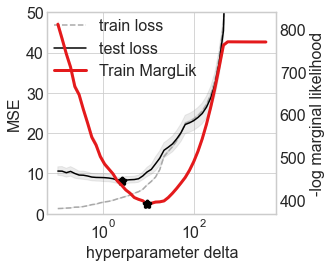

In [96]:
test = 'black'
train = 'darkgray'

plt.style.use('seaborn-white')
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 16
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.family'] = 'sans-serif'
#plt.rc('text', usetex=True)
bmap = brewer2mpl.get_map('Set1', 'qualitative', 6)
colors = bmap.mpl_colors

vlap = colors[1]
clap = colors[0]
test = 'black'
train = 'darkgray'

produce_paper_uci_plots('boston')